In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout, LeakyReLU, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

output_dir = "drive/MyDrive/"

data = np.load(output_dir + "remiss_test_obt.npz")

lon = data['lon']
lat = data['lat']

lon_norm = (lon / 180.0).reshape(-1, 1)
lat_norm = (lat / 90.0).reshape(-1, 1)

print(list(data.keys()))

datax = data['datax']
dataz = data['dataz']
# datay = data['datay']
sfctype = data['sfctype']

# intern project input
input_data = np.concatenate((datax[:, 0:2], dataz, lon_norm, lat_norm), axis = 1)
labels = datax[:, 25:207]
print(input_data.shape)

# Delete unused arrays for memory
del data
del datax
del dataz

train_x, temp_x, train_y, temp_y = train_test_split(input_data, labels, test_size = 0.4444, random_state = 42)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size = 0.5, random_state = 42)

del input_data
del labels
del temp_x

#Split data sets
train_y_temp, train_y_vapor = train_y[:, :91], train_y[:, 91:]
val_y_temp, val_y_vapor = val_y[:, :91], val_y[:, 91:]
test_y_temp, test_y_vapor = test_y[:, :91], test_y[:, 91:]

del train_y
del val_y
del test_y

# Normalize Data
scaler_input = StandardScaler()
scaler_temp_labels = StandardScaler()
scaler_vapor_labels = StandardScaler()

scaler_input.fit(train_x)
scaler_temp_labels.fit(train_y_temp)
scaler_vapor_labels.fit(train_y_vapor)

train_x_scaled = scaler_input.transform(train_x)
del train_x
val_x_scaled = scaler_input.transform(val_x)
del val_x
test_x_scaled = scaler_input.transform(test_x)
del test_x

train_y_temp_scaled = scaler_temp_labels.transform(train_y_temp)
del train_y_temp
val_y_temp_scaled = scaler_temp_labels.transform(val_y_temp)
del val_y_temp
test_y_temp_scaled = scaler_temp_labels.transform(test_y_temp)

train_y_vapor_scaled = scaler_vapor_labels.transform(train_y_vapor)
del train_y_vapor
val_y_vapor_scaled = scaler_vapor_labels.transform(val_y_vapor)
del val_y_vapor
test_y_vapor_scaled = scaler_vapor_labels.transform(test_y_vapor)

['lon', 'lat', 'sfctype', 'asds', 'datax', 'dataz', 'datay', 'datayc', 'datayd', 'dataycd']
(1866585, 26)


In [ ]:
# @title
# Model Architecture

from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Add, ReLU, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers.schedules import CosineDecay


inputs = Input(shape = (26, ))
x = Dense(512)(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.13)(x)
x = Dropout(0.3)(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.13)(x)
x = Dropout(0.3)(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.13)(x)
x = Dropout(0.3)(x)

# Temperature head
temp_head = Dense(256)(x)
temp_head = BatchNormalization()(temp_head)
temp_head = LeakyReLU(0.13)(temp_head)
temp_head = Dropout(0.3)(temp_head)

temp_output = Dense(91, name = 'temperature_output')(temp_head)

# Water vapor head
vapor_head = Dense(256)(x)
vapor_head = BatchNormalization()(vapor_head)
vapor_head = LeakyReLU(0.13)(vapor_head)
vapor_head = Dropout(0.3)(vapor_head)

vapor_output = Dense(91, name = 'vapor_output')(vapor_head)

# Create Model and Compile
model = Model(inputs = inputs, outputs = [temp_output, vapor_output])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss = {'temperature_output': 'mse', 'vapor_output': 'mse'}, metrics = {'temperature_output': ['mse','mae'], 'vapor_output':['mae']}, loss_weights = {'temperature_output': 0.75, 'vapor_output': 0.25})

# Callbacks
stop = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

# Train model
history = model.fit(train_x_scaled, {'temperature_output': train_y_temp_scaled, 'vapor_output': train_y_vapor_scaled}, validation_data = (val_x_scaled, {'temperature_output': val_y_temp_scaled, 'vapor_output': val_y_vapor_scaled}), epochs = 300, batch_size = 2048, callbacks = [stop])

# Denormalize Predictions
final_preds_scaled = model.predict(test_x_scaled)
final_preds_temp_scaled = final_preds_scaled[0]
final_preds_vapor_scaled = final_preds_scaled[1]

final_preds_temp_denorm = scaler_temp_labels.inverse_transform(final_preds_temp_scaled)
final_preds_vapor_denorm = scaler_vapor_labels.inverse_transform(final_preds_vapor_scaled)

final_temp_mse_denorm = mean_squared_error(test_y_temp, final_preds_temp_denorm)
final_temp_mae_denorm = mean_absolute_error(test_y_temp, final_preds_temp_denorm)

final_vapor_mse_denorm = mean_squared_error(test_y_vapor, final_preds_vapor_denorm)
final_vapor_mae_denorm = mean_absolute_error(test_y_vapor, final_preds_vapor_denorm)

print(f"Temperature MSE: {final_temp_mse_denorm:.4f}")
print(f"Temperature MAE: {final_temp_mae_denorm:.4f}")
print(f"Vapor MSE: {final_vapor_mse_denorm:.4f}")
print(f"Vapor MAE: {final_vapor_mae_denorm:.4f}")


Epoch 1/300


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/func_graph.py", line 1060, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 599, in wrapped_fn
    out = weak_wrapped_fn().__wrapped__(*args, **kwds)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/autograph_util.py", line 41, in autograph_handler
    return api.converted_call(
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 331, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/

TypeError: object of type 'NoneType' has no len()

In [ ]:
# @title
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Add, ReLU, MultiHeadAttention, Reshape, LayerNormalization
from tensorflow.keras.optimizers import RMSprop, AdamW
from keras import ops

def residual_block(x, units):
  shortcut = x
  x = Dense(units, kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Dropout(0.25)(x)
  x = Dense(units, kernel_initializer='he_normal')(x)

  # If dimensions don't match, project shortcut
  if shortcut.shape[-1] != x.shape[-1]:
      shortcut = Dense(units, kernel_initializer='he_normal')(shortcut)

  x = Add()([x, shortcut])
  x = ReLU()(x)
  return x

inputs = Input(shape = (26, ))
x = Dense(256, activation='relu')(inputs)
x = residual_block(x, 512)
x = residual_block(x, 512)
x = residual_block(x, 512)
x = residual_block(x, 1024)

x_exp = tf.keras.layers.Reshape((1, -1))(x)
x_attn = MultiHeadAttention(num_heads=2, key_dim=64)(x_exp, x_exp)
x = Add()([x_exp, x_attn])
x = tf.keras.layers.Reshape((-1,))(x)

# Temperature head
temp_head = Dense(512, activation = 'relu')(x)

temp_sub1 = Dense(256)(temp_head)
temp_sub1 = LeakyReLU(0.13)(temp_sub1)
temp_sub1 = Dense(512)(temp_sub1)
temp_sub1 = LeakyReLU(0.13)(temp_sub1)
temp_sub1 = Dense(256, activation = 'relu')(temp_sub1)
temp_out1 = Dense(10)(temp_sub1)

temp_sub2 = Dense(256)(temp_head)
temp_sub2 = LeakyReLU(0.13)(temp_sub2)
temp_sub2 = Dense(512)(temp_sub2)
temp_sub2 = LeakyReLU(0.13)(temp_sub2)
temp_sub2 = Dense(256, activation = 'relu')(temp_sub2)
temp_out2 = Dense(10)(temp_sub2)

temp_sub3 = Dense(256, activation = 'relu')(temp_head)
temp_out3 = Dense(45)(temp_sub3)

temp_sub4 = Dense(256)(temp_head)
temp_sub4 = LeakyReLU(0.1)(temp_sub4)
temp_sub4 = Dense(128, activation = 'relu')(temp_sub4)
temp_out4 = Dense(26)(temp_sub4)

temp_output = Concatenate(name = 'temperature_output')([temp_out1, temp_out2, temp_out3, temp_out4])

# Water vapor head
vapor_head = Dense(512, activation = 'relu')(x)

vapor_sub1 = Dense(256, activation = 'relu')(vapor_head)
vapor_out1 = Dense(60)(vapor_sub1)

vapor_sub2 = Dense(256, activation = 'relu')(vapor_head)
vapor_sub2 = Dense(512, activation = 'relu')(vapor_sub2)
vapor_sub2 = Dense(256, activation = 'relu')(vapor_sub2)
vapor_out2 = Dense(31)(vapor_sub2)

vapor_output = Concatenate(name = 'vapor_output')([vapor_out1, vapor_out2])

# Create Model and Compile
model = Model(inputs = inputs, outputs = [temp_output, vapor_output])

optimizer = AdamW(learning_rate=0.001, weight_decay=2e-3)
model.compile(optimizer = optimizer, loss = {'temperature_output': 'mse', 'vapor_output': 'mse'}, metrics = {'temperature_output': ['mse','mae'], 'vapor_output':['mae']}, loss_weights = {'temperature_output': 0.75, 'vapor_output': 0.25})

# First training for weighted MSE
first_batch = model.fit(train_x_scaled, {'temperature_output': train_y_temp_scaled, 'vapor_output': train_y_vapor_scaled}, validation_data = (val_x_scaled, {'temperature_output': val_y_temp_scaled, 'vapor_output': val_y_vapor_scaled}), epochs = 30, batch_size = 1024)

preds = model.predict(test_x_scaled)

# Compute Per-Target MSE and create custom weighted loss
preds_temp = preds[0]
preds_vapor = preds[1]

temp_mse = np.mean((preds_temp - test_y_temp_scaled) ** 2, axis = 0)
vapor_mse = np.mean((preds_vapor - test_y_vapor_scaled) ** 2, axis = 0)

epsilon = 1e-8
temp_weights = 1.0 / (temp_mse + epsilon)
temp_weights /= np.sum(temp_weights)

vapor_weights = 1.0 / (vapor_mse + epsilon)
vapor_weights /= np.sum(vapor_weights)

temp_tensor = tf.constant(temp_weights, dtype=tf.float32)
vapor_tensor = tf.constant(vapor_weights, dtype=tf.float32)

# Custom Loss functions
def weighted_mse_temp(y_true, y_pred):
  error = tf.square(y_true - y_pred)
  weighted_error = error * temp_tensor
  return tf.reduce_mean(weighted_error)

def weighted_mse_vapor(y_true, y_pred):
  error = tf.square(y_true - y_pred)
  weighted_error = error * vapor_tensor
  return tf.reduce_mean(weighted_error)

# Compile model using weighted MSE values
model.compile(optimizer = optimizer,  loss = {'temperature_output': weighted_mse_temp, 'vapor_output': weighted_mse_vapor},
                                      metrics = {'temperature_output': ['mse', 'mae'],'vapor_output': ['mse', 'mae']},
                                      loss_weights = {'temperature_output': 0.75, 'vapor_output': 0.25})

# Callbacks
stop = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

# Train model
history = model.fit(train_x_scaled, {'temperature_output': train_y_temp_scaled, 'vapor_output': train_y_vapor_scaled}, validation_data = (val_x_scaled, {'temperature_output': val_y_temp_scaled, 'vapor_output': val_y_vapor_scaled}), epochs = 300, batch_size = 2048, callbacks = [stop])

# Denormalize Predictions
# final_preds_scaled = model.predict(test_x_scaled)
# final_preds_temp_scaled = final_preds_scaled[0]
# final_preds_vapor_scaled = final_preds_scaled[1]

# final_preds_temp_denorm = scaler_temp_labels.inverse_transform(final_preds_temp_scaled)
# final_preds_vapor_denorm = scaler_vapor_labels.inverse_transform(final_preds_vapor_scaled)

# final_temp_mse_denorm = mean_squared_error(test_y_temp, final_preds_temp_denorm)
# final_temp_mae_denorm = mean_absolute_error(test_y_temp, final_preds_temp_denorm)

# final_vapor_mse_denorm = mean_squared_error(test_y_vapor, final_preds_vapor_denorm)
# final_vapor_mae_denorm = mean_absolute_error(test_y_vapor, final_preds_vapor_denorm)

# print(f"Temperature MSE: {final_temp_mse_denorm:.4f}")
# print(f"Temperature MAE: {final_temp_mae_denorm:.4f}")
# print(f"Vapor MSE: {final_vapor_mse_denorm:.4f}")
# print(f"Vapor MAE: {final_vapor_mae_denorm:.4f}")

Epoch 1/30
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 197s 125ms/step - loss: 0.1962 - temperature_output_loss: 0.1559 - temperature_output_mae: 0.2413 - temperature_output_mse: 0.1559 - vapor_output_loss: 0.3171 - vapor_output_mae: 0.3609 - val_loss: 0.0640 - val_temperature_output_loss: 0.0402 - val_temperature_output_mae: 0.1418 - val_temperature_output_mse: 0.0402 - val_vapor_output_loss: 0.1356 - val_vapor_output_mae: 0.2337
Epoch 2/30
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0581 - temperature_output_loss: 0.0347 - temperature_output_mae: 0.1295 - temperature_output_mse: 0.0347 - vapor_output_loss: 0.1280 - vapor_output_mae: 0.2242 - val_loss: 0.0450 - val_temperature_output_loss: 0.0262 - val_temperature_output_mae: 0.1163 - val_temperature_output_mse: 0.0262 - val_vapor_output_loss: 0.1011 - val_vapor_output_mae: 0.1934
Epoch 3/30
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0451 - temperature_output_loss: 0.0256 - temperature_output_mae: 0.1119 - temperature_output

In [ ]:
data = np.load(output_dir + "test_ws_sca_obts_210326.npz")

lon = data['lon']
lat = data['lat']

lon_norm = (lon / 180.0).reshape(-1, 1)
lat_norm = (lat / 90.0).reshape(-1, 1)

print(list(data.keys()))

datax = data['datax']
dataz = data['dataz']
# datay = data['datay']
sfctype = data['sfctype']

# intern project input
input_data = np.concatenate((datax[:, 0:2], dataz, lon_norm, lat_norm), axis = 1)
labels = datax[:, 25:207]
print(input_data.shape)

label_t, label_v = labels[:, :91], labels[:, 91:]

input_data = scaler_input.transform(input_data)
# label_t = scaler_temp_labels.transform(label_t)
# label_v = scaler_vapor_labels.transform(label_v)

final_preds_scaled = model.predict(input_data)

final_preds_temp_scaled = final_preds_scaled[0]
final_preds_vapor_scaled = final_preds_scaled[1]

final_preds_temp_denorm = scaler_temp_labels.inverse_transform(final_preds_temp_scaled)
final_preds_vapor_denorm = scaler_vapor_labels.inverse_transform(final_preds_vapor_scaled)

final_temp_mse_denorm = mean_squared_error(label_t, final_preds_temp_denorm)
final_temp_mae_denorm = mean_absolute_error(label_t, final_preds_temp_denorm)

final_vapor_mse_denorm = mean_squared_error(label_v, final_preds_vapor_denorm)
final_vapor_mae_denorm = mean_absolute_error(label_v, final_preds_vapor_denorm)

print(f"Temperature MSE: {final_temp_mse_denorm:.4f}")
print(f"Temperature MAE: {final_temp_mae_denorm:.4f}")
print(f"Vapor MSE: {final_vapor_mse_denorm:.4f}")
print(f"Vapor MAE: {final_vapor_mae_denorm:.4f}")


['lon', 'lat', 'sfctype', 'asds', 'datax', 'dataz', 'ws', 'wsd', 'sca', 'rza', 'sunza', 'cwv']
(155520, 26)
4860/4860 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Temperature MSE: 7.7702
Temperature MAE: 1.9065
Vapor MSE: 0.2598
Vapor MAE: 0.1889


In [ ]:
# @title
import pandas as pd

# Sample index
sample_ids = np.arange(final_preds_temp_denorm.shape[0])

# Create DataFrames
df_pred_temp = pd.DataFrame(final_preds_temp_denorm, columns=[f"pred_temp_{i}" for i in range(final_preds_temp_denorm.shape[1])])
df_true_temp = pd.DataFrame(label_t, columns=[f"true_temp_{i}" for i in range(label_t.shape[1])])

df_pred_vapor = pd.DataFrame(final_preds_vapor_denorm, columns=[f"pred_vapor_{i}" for i in range(final_preds_vapor_denorm.shape[1])])
df_true_vapor = pd.DataFrame(label_v, columns=[f"true_vapor_{i}" for i in range(label_v.shape[1])])

# Combine all into one DataFrame
df_all = pd.concat([
    pd.Series(sample_ids, name="sample_id"),
    df_pred_temp, df_true_temp,
    df_pred_vapor, df_true_vapor
], axis=1)

# Save to CSV
df_all.to_csv("test_2.csv", index=False)

In [ ]:
# @title
import zipfile

with zipfile.ZipFile("test_2.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("test_2.csv")


In [ ]:
# @title
!cp test_2.zip /content/drive/MyDrive/

In [ ]:
# @title
import zipfile
import os

# Path to your ZIP in Google Drive
zip_path = "drive/MyDrive/test_1.zip"
zip_path2 = "drive/MyDrive/test_2.zip"

# Unzip location (in working directory)
extract_dir = "/content/extracted_csvs"
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

lay_p = np.array([
    0.01000,
    0.02990,
    0.05684,
    0.10148,
    0.17161,
    0.27683,
    0.42850,
    0.63957,
    0.92442,
    1.29851,
    1.77812,
    2.37997,
    3.12090,
    4.01755,
    5.08603,
    6.34166,
    7.79880,
    9.47056,
    11.36876,
    13.50375,
    15.88437,
    18.51792,
    21.41015,
    24.56527,
    27.98600,
    31.67364,
    35.62811,
    39.84806,
    44.33096,
    49.07318,
    54.07008,
    59.31498,
    64.79783,
    70.50598,
    76.42905,
    82.57262,
    88.95865,
    95.61652,
    102.58014,
    109.88911,
    117.59068,
    125.73970,
    134.38925,
    143.57735,
    153.33417,
    163.69049,
    174.67924,
    186.33441,
    198.69090,
    211.78708,
    225.66202,
    240.35611,
    255.91249,
    272.37567,
    289.79242,
    308.21136,
    327.68323,
    348.26105,
    369.99963,
    392.95676,
    417.18536,
    442.72168,
    469.46347,
    497.17096,
    525.58557,
    554.43005,
    583.42126,
    612.33783,
    641.03186,
    669.37561,
    697.25085,
    724.51801,
    751.03076,
    776.67151,
    801.33704,
    824.90863,
    847.26544,
    868.31836,
    888.00159,
    906.24243,
    922.96521,
    938.13074,
    951.73315,
    963.77094,
    974.23828,
    983.16626,
    990.81342,
    997.32812,
    1002.59778,
    1006.61053,
    1009.50665])

# Get all CSVs in extracted folder
csv_files = "extracted_csvs/"

df = pd.read_csv(csv_files + "test_1.csv")

pred_temp_cols = [col for col in df.columns if col.startswith("pred_temp_")]
pred_vapor_cols = [col for col in df.columns if col.startswith("pred_vapor_")]
true_temp_cols = [col for col in df.columns if col.startswith("true_temp_")]
true_vapor_cols = [col for col in df.columns if col.startswith("true_vapor_")]

# Extract arrays
pred_temp_1 = df[pred_temp_cols].to_numpy()
pred_vapor_1 = df[pred_vapor_cols].to_numpy()
true_temp = df[true_temp_cols].to_numpy()
true_vapor = df[true_vapor_cols].to_numpy()

print(pred_temp_1.shape)
print(pred_vapor_1.shape)
print(true_temp.shape)
print(true_vapor.shape)

df = pd.read_csv(csv_files + "test_2.csv")

pred_temp_cols = [col for col in df.columns if col.startswith("pred_temp_")]
pred_vapor_cols = [col for col in df.columns if col.startswith("pred_vapor_")]
true_temp_cols = [col for col in df.columns if col.startswith("true_temp_")]
true_vapor_cols = [col for col in df.columns if col.startswith("true_vapor_")]

true_temp_2 = df[true_temp_cols].to_numpy()
true_vapor_2 = df[true_vapor_cols].to_numpy()
pred_temp_2 = df[pred_temp_cols].to_numpy()
pred_vapor_2 = df[pred_vapor_cols].to_numpy()

print(pred_temp_2.shape)
print(pred_vapor_2.shape)
print(true_temp_2.shape)
print(true_vapor_2.shape)


(155520, 365)
(155520, 91)
(155520, 91)
(155520, 91)
(155520, 91)
(155520, 91)
(155520, 91)
(155520, 91)
(155520, 91)


In [ ]:
output_dir = "drive/MyDrive/"

data = np.load(output_dir + "test_ws_sca_obts_210326.npz")
sfctype_2 = data['sfctype']

print(sfctype.shape)

data = np.load(output_dir + "test_ws_sca_obts_201127.npz")
sfctype = data['sfctype']

(155520,)


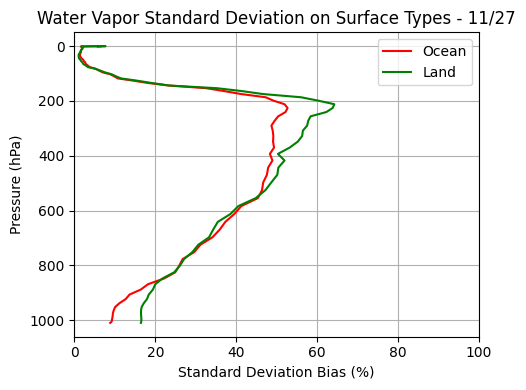

In [ ]:
from sklearn.model_selection import train_test_split

sfctype = sfctype.flatten()  # Ensure shape (n_samples,)

ocean_mask = sfctype == 17
ice_mask   = sfctype == 15
land_mask  = ~(ocean_mask | ice_mask)

bias_t = true_temp - pred_temp_1
bias_v = true_vapor - pred_vapor_1
vapor_ave = np.mean(true_vapor, axis=0) + 1.0e-6

land_bias_v = np.std(bias_v[land_mask], axis = 0)
ocean_bias_v = np.std(bias_v[ocean_mask], axis = 0)

bias_t_2 = true_temp_2 - pred_temp_2
bias_v_2 = true_vapor_2 - pred_vapor_2
vapor_ave_2 = np.mean(true_vapor, axis=0) + 1.0e-6

sfctype_2 = sfctype_2.flatten()  # Ensure shape (n_samples,)

ocean_mask_2 = sfctype_2 == 17
ice_mask_2   = sfctype_2 == 15
land_mask_2  = ~(ocean_mask | ice_mask)

land_bias_v_2 = np.std(bias_v[land_mask_2], axis = 0)
ocean_bias_v_2 = np.std(bias_v[ocean_mask_2], axis = 0)

plt.figure(figsize = (5.122, 4))
plt.plot(100 * (ocean_bias_v/vapor_ave), lay_p, label='Ocean', color='red')
plt.plot(100 * (land_bias_v/vapor_ave), lay_p, label= 'Land', color='green')
# plt.plot(100 * (ocean_bias_v_2/vapor_ave_2), lay_p, label='Ocean', color='red', linestyle = '--')
# plt.plot(100 * (land_bias_v_2/vapor_ave_2), lay_p, label= 'Land', color='green', linestyle = '--')
plt.xlabel("Standard Deviation Bias (%)")
plt.ylabel("Pressure (hPa)")
plt.title("Water Vapor Standard Deviation on Surface Types - 11/27")
plt.xlim(0, 100)
# plt.ylim(100, 950)
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

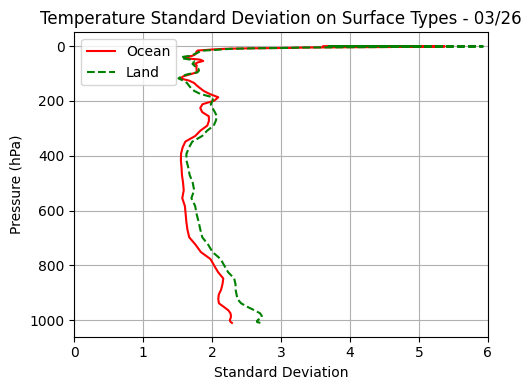

In [ ]:
bias_t = true_temp_2 - pred_temp_2

land_bias_t = np.std(bias_t[land_mask_2], axis = 0)
ocean_bias_t = np.std(bias_t[ocean_mask_2], axis = 0)

plt.figure(figsize = (5.122, 4))
plt.plot(ocean_bias_t, lay_p, label='Ocean', color='red')
plt.plot(land_bias_t, lay_p, label= 'Land', color='green', linestyle = '--')

plt.xlabel("Standard Deviation")
plt.ylabel("Pressure (hPa)")
plt.title("Temperature Standard Deviation on Surface Types - 03/26")
plt.xlim(0, 6)
# plt.ylim(-, 1000)
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# @title
import cartopy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d

lon_train, lon_temp, lat_train, lat_temp = train_test_split(lon, lat, test_size=0.4444, random_state=42)
lon_val, lon_test, lat_val, lat_test = train_test_split(lon_temp, lat_temp, test_size=0.5, random_state=42)

# Constants
lat_bins = np.linspace(-90, 90, 181)
lon_bins = np.linspace(-180.01, 180.01, 361)
lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2

# Compute squared error (sample x level)
temp_mse = (true_temp - pred_temp_all) ** 2  # shape: (n_samples, 91)
vapor_mse = (true_vapor - pred_vapor_all) **2

# Split into 10 groups of ~9 levels
level_splits = np.array_split(np.arange(temp_mse.shape[1]), 10)

def setup_map():
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    title = ax.set_title("")
    return fig, ax, title

def make_10frame_animation(squared_error, lay_p, lat_test, lon_test, filename, vmin, vmax, label="MSE (unit²)"):
    fig, ax, title = setup_map()

    mesh = ax.pcolormesh(lon_centers, lat_centers, np.zeros((180, 360)),
                         cmap='coolwarm', vmin=vmin, vmax=vmax, shading='auto')
    plt.colorbar(mesh, ax=ax, orientation='vertical', label=label)

    def update(i):
        idxs = level_splits[i]
        pressure_range = lay_p[idxs]
        averaged_error = np.mean(squared_error[:, idxs], axis=1)

        grid, _, _, _ = binned_statistic_2d(
            lon_test, lat_test, averaged_error, statistic='mean', bins=[lon_bins, lat_bins]
        )
        grid = np.nan_to_num(grid, nan=np.nan)
        mesh.set_array(grid.T.flatten())

        title.set_text(f"Mean MSE from {pressure_range.min():.1f} to {pressure_range.max():.1f} hPa (Levels {idxs[0]}–{idxs[-1]})")
        return mesh, title

    anim = FuncAnimation(fig, update, frames=len(level_splits), interval=2000)
    anim.save(filename, writer=FFMpegWriter(fps=1))
    plt.close()
    print(f"Saved animation to {filename}")

# Call the function for temperature
make_10frame_animation(temp_mse, lay_p, lat_test, lon_test,
                       filename="temp_mse_10frames.mp4", vmin = 0, vmax=2.5, label="Temperature MSE")
make_10frame_animation(vapor_mse, lay_p, lat_test, lon_test,
                       filename="vapor_mse_10frames.mp4", vmin = 0, vmax=1.0, label="Vapor MSE")

Saved animation to temp_mse_10frames.mp4
Saved animation to vapor_mse_10frames.mp4


In [ ]:
# @title
from google.colab import files
files.download("temp_mse_10frames.mp4")
files.download("vapor_mse_10frames.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

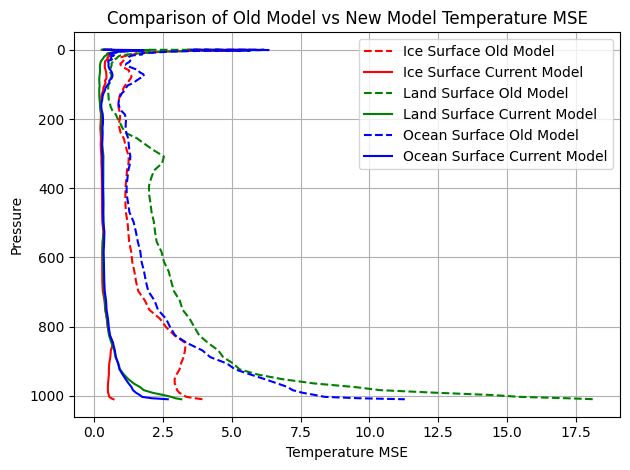

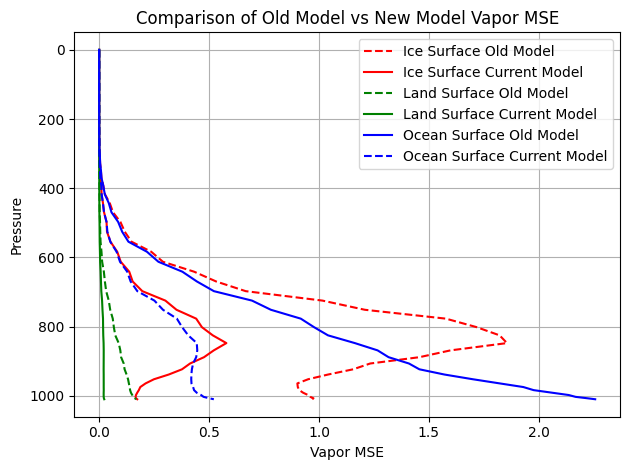

In [ ]:
# @title


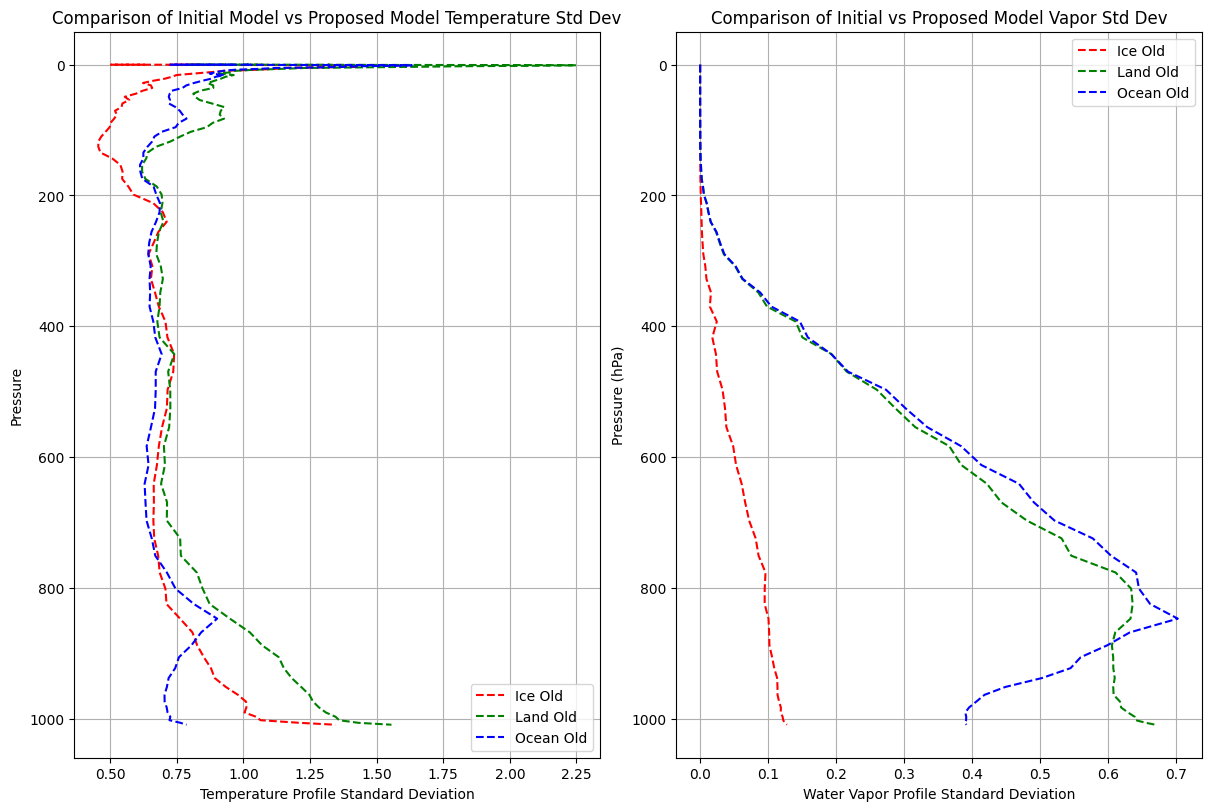

In [ ]:
# @title

ig, axs = plt.subplots(1, 2, figsize=(12, 8), dpi=100,
                        sharex=False, sharey=False,
                        constrained_layout=True)

sfctype = sfctype.flatten()  # Ensure shape (n_samples,)

sfctype_train, sfctype_temp = train_test_split(sfctype, test_size=0.4444, random_state=42)
sfctype_val, sfctype_test = train_test_split(sfctype_temp, test_size=0.5, random_state=42)

sfctype_test = np.array(sfctype_test).flatten()

ocean_mask = sfctype_test == 17
ice_mask   = sfctype_test == 15
land_mask  = ~(ocean_mask | ice_mask)

temp_mse = (true_temp_1 - pred_temp_old)**2
vapor_mse = (true_vapor_1 - pred_vapor_old)**2
temp_mse_2 = (true_temp_2 - pred_temp_no_y)**2
vapor_mse_2 = (true_vapor_2 - pred_vapor_no_y)**2

ice_mse_old = np.mean(temp_mse[ice_mask], axis = 0)
land_mse_old = np.mean(temp_mse[land_mask], axis = 0)
ocean_mse_old = np.mean(temp_mse[ocean_mask], axis = 0)

# ice_mse_new = np.mean(temp_mse_2[ice_mask], axis = 0)
# land_mse_new = np.mean(temp_mse_2[land_mask], axis = 0)
# ocean_mse_new = np.mean(temp_mse_2[ocean_mask], axis = 0)

temp_bias = true_temp_1 - pred_temp_old
vapor_bias = true_vapor_1 - pred_vapor_old
temp_bias_2 = true_temp_2 - pred_temp_no_y
vapor_bias_2 = true_vapor_2 - pred_vapor_no_y

ocean_std_old = np.std(vapor_bias[ocean_mask], axis=0)
# ocean_std_new = np.std(vapor_bias_2[ocean_mask], axis=0)

land_std_old = np.std(vapor_bias[land_mask], axis=0)
# land_std_new = np.std(vapor_bias_2[land_mask], axis=0)

ice_std_old = np.std(vapor_bias[ice_mask], axis=0)
# ice_std_new = np.std(vapor_bias_2[ice_mask], axis=0)

ax = axs[1]
ax.plot(ice_std_old, lay_p, label='Ice Old', color='red', linestyle = '--')
# ax.plot(ice_std_new, lay_p, label='Ice Current', color='red')
ax.plot(land_std_old, lay_p, label='Land Old', color='green', linestyle = '--')
# ax.plot(land_std_new, lay_p, label='Land Current', color='green')
ax.plot(ocean_std_old, lay_p, label='Ocean Old', color='blue', linestyle = '--')
# ax.plot(ocean_std_new, lay_p, label='Ocean Current', color='blue')

ax.set_xlabel("Water Vapor Profile Standard Deviation")
ax.set_ylabel("Pressure (hPa)")
ax.set_title("Comparison of Initial vs Proposed Model Vapor Std Dev")
ax.invert_yaxis()
ax.legend()
ax.grid(True)

ocean_std_old = np.std(temp_bias[ocean_mask], axis=0)
# ocean_std_new = np.std(temp_bias_2[ocean_mask], axis=0)

land_std_old = np.std(temp_bias[land_mask], axis=0)
# land_std_new = np.std(temp_bias_2[land_mask], axis=0)

ice_std_old = np.std(temp_bias[ice_mask], axis=0)
# ice_std_new = np.std(temp_bias_2[ice_mask], axis=0)

ax = axs[0]
ax.plot(ice_std_old, lay_p, label='Ice Old', color='red', linestyle = '--')
# ax.plot(ice_std_new, lay_p, label='Ice Current', color='red')
ax.plot(land_std_old, lay_p, label='Land Old', color='green', linestyle = '--')
# ax.plot(land_std_new, lay_p, label='Land Current', color='green')
ax.plot(ocean_std_old, lay_p, label='Ocean Old', color='blue', linestyle = '--')
# ax.plot(ocean_std_new, lay_p, label='Ocean Current', color='blue')

ax.set_xlabel("Temperature Profile Standard Deviation")
ax.set_ylabel("Pressure")
ax.set_title("Comparison of Initial Model vs Proposed Model Temperature Std Dev")
ax.invert_yaxis()
ax.legend()
ax.grid(True)

plt.show()

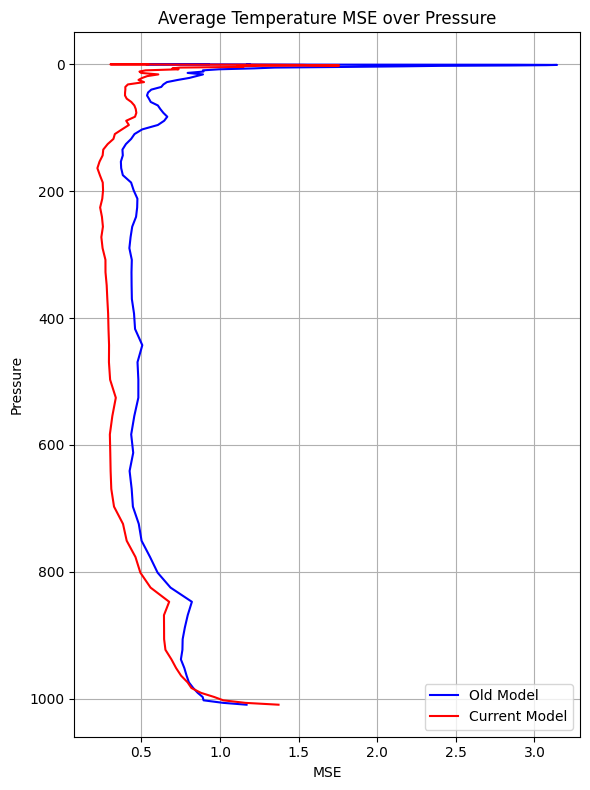

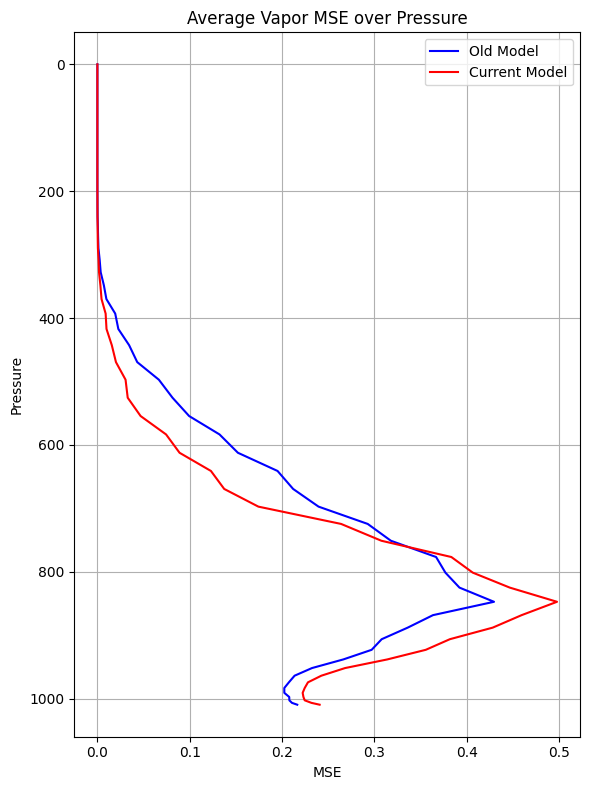

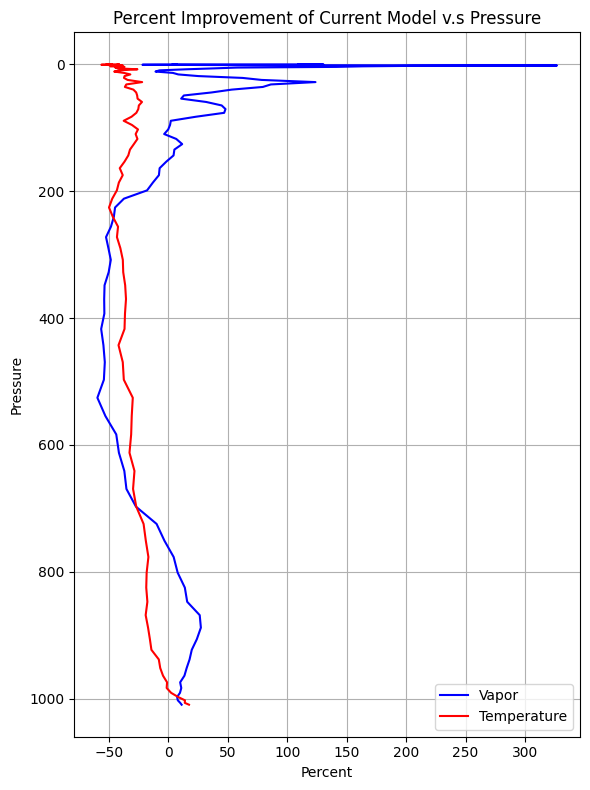

-0.3045090059442955
0.13770530469272793


In [ ]:
temp_mse = (np.mean((true_temp_1 - pred_temp_old) ** 2, axis = 0))
vapor_mse = (np.mean((true_vapor_1 - pred_vapor_old) ** 2 , axis = 0))
temp_mse_2 = (np.mean((true_temp_2 - pred_temp_no_y) ** 2, axis = 0))
vapor_mse_2 = (np.mean((true_vapor_2 - pred_vapor_no_y) ** 2, axis = 0))

plt.figure(figsize = (6, 8))
plt.plot(temp_mse, lay_p, label='Old Model', color='blue')
plt.plot(temp_mse_2, lay_p, label='Current Model', color='red')

plt.xlabel("MSE")
plt.ylabel("Pressure")
plt.title("Average Temperature MSE over Pressure")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize = (6, 8))
plt.plot(vapor_mse, lay_p, label='Old Model', color='blue')
plt.plot(vapor_mse_2, lay_p, label='Current Model', color='red')

plt.xlabel("MSE")
plt.ylabel("Pressure")
plt.title("Average Vapor MSE over Pressure")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

temp_percent = [((a-b)/b) * 100 for a, b in zip(temp_mse_2, temp_mse)]
vapor_percent = [((a-b)/b) * 100 for a, b in zip(vapor_mse_2, vapor_mse)]

plt.figure(figsize = (6, 8))
plt.plot(vapor_percent, lay_p, label='Vapor', color='blue')
plt.plot(temp_percent, lay_p, label='Temperature', color='red')

plt.xlabel("Percent")
plt.ylabel("Pressure")
plt.title("Percent Improvement of Current Model v.s Pressure")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(np.mean((temp_mse_2 - temp_mse)/temp_mse, axis = 0))
print(np.mean((vapor_mse_2 - vapor_mse)/vapor_mse, axis = 0))

In [ ]:
# @title
!pip install cartopy

import cartopy

import scipy.stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lon_train, lon_temp, lat_train, lat_temp = train_test_split(lon, lat, test_size=0.4444, random_state=42)
lon_val, lon_test, lat_val, lat_test = train_test_split(lon_temp, lat_temp, test_size=0.5, random_state=42)

# Define bin edges (1-degree resolution)
lat_bins = np.linspace(-90, 90, 181)
lon_bins = np.linspace(-180.01, 180.01, 361)

temp_mse = np.mean((test_y_temp - final_preds_temp_denorm)**2, axis=1)
vapor_mse = np.mean((test_y_vapor - final_preds_vapor_denorm)**2, axis=1)

# Compute binned statistic (mean absolute error per grid cell)
grid_temp_mse, _, _, _ = scipy.stats.binned_statistic_2d(
    lon_test, lat_test, temp_mse, statistic='mean', bins=[lon_bins, lat_bins]
)

grid_vapor_mse, _, _, _ = scipy.stats.binned_statistic_2d(
    lon_test, lat_test, vapor_mse, statistic='mean', bins=[lon_bins, lat_bins]
)

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot with pcolormesh
lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
mesh = ax.pcolormesh(lon_centers, lat_centers, grid_temp_mse.T,
                     cmap='coolwarm', vmin = 0, vmax = 3.0, shading='auto')

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title("Global Temperature MSE")
plt.colorbar(mesh, ax=ax, orientation='vertical', label='MSE (K)')
plt.tight_layout()
plt.show()

fig2 = plt.figure(figsize=(12, 6))
ax2 = plt.axes(projection=ccrs.PlateCarree())

# Plot with pcolormesh
lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
mesh = ax2.pcolormesh(lon_centers, lat_centers, grid_vapor_mse.T,
                     cmap='coolwarm', vmin = 0, vmax = 0.5, shading='auto')

# Add map features
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.set_title("Global Vapor MSE")
plt.colorbar(mesh, ax=ax2, orientation='vertical', label='MSE')
plt.tight_layout()
plt.show()


In [ ]:
# @title
from scipy.stats import binned_statistic_2d
from matplotlib.animation import FuncAnimation, FFMpegWriter

lat_bins = np.linspace(-90, 90, 181)
lon_bins = np.linspace(-180, 180, 361)
lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
vmin, vmax_temp = 0, 3.0
vmin, vmax_vapor = 0, 0.5


temp_mse = (test_y_temp - final_preds_temp_denorm) ** 2    # (n_samples, 91)
vapor_mse = (test_y_vapor - final_preds_vapor_denorm) ** 2

def setup_map():
    fig = plt.figure(figsize=(12, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    title = ax.set_title("")
    return fig, ax, title

def make_animation(squared_error, lay_p, lat_test, lon_test, filename, vmax, label="MSE (unit²)"):
    fig, ax, title = setup_map()

    mesh = ax.pcolormesh(lon_centers, lat_centers,
                         np.zeros((180, 360)),  # Empty base grid
                         cmap='coolwarm', shading='auto',
                         vmin=0, vmax=vmax)
    plt.colorbar(mesh, ax=ax, orientation='vertical', label=label)

    def update(level):
        err = squared_error[:, level]
        grid, _, _, _ = binned_statistic_2d(
            lon_test, lat_test, err, statistic='mean', bins=[lon_bins, lat_bins]
        )
        grid = np.nan_to_num(grid, nan=np.nan)
        mesh.set_array(grid.T.flatten())
        title.set_text(f"MSE at {lay_p[level]:.1f} hPa (Level {level})")
        return mesh, title

    anim = FuncAnimation(fig, update, frames=91, interval=250)
    anim.save(filename, writer=FFMpegWriter(fps=6))
    plt.close()
    print(f"Saved: {filename}")

make_animation(temp_mse, lay_p, lat_test, lon_test,
               filename="temperature_mse_by_altitude.mp4",
               vmax=vmax_temp, label="Temperature MSE")

make_animation(vapor_mse, lay_p, lat_test, lon_test,
               filename="vapor_mse_by_altitude.mp4",
               vmax=vmax_vapor, label="Vapor MSE")